In [16]:
# Import standard libraries for deep learning, metrics, image processing, and multiprocessing
import os
import copy
import torch
import torch.nn as nn
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, Subset, DistributedSampler, SubsetRandomSampler
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torchvision.transforms as transforms

In [21]:
# Custom dataset class for loading jet images and their labels
class JetImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir # Directory where images are stored
        self.transform = transform # Image transformations to be applied
        self.images = []  # List to hold image filenames
        self.labels = []  # List to hold labels

        # Traverse the directory and label each image as gluon (0) or quark (1)
        for filename in os.listdir(root_dir):
            if filename.endswith(".png"):
                for i in range(5):
                    if f"type{i}" in filename:
                        label = i
                        self.images.append(filename)
                        self.labels.append(label)
                        break

    def __len__(self):
        return len(self.images) # Total number of images

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.images[idx]) # Construct full path to image
        image = Image.open(img_path).convert("RGB")  # The images are converted to RGB format

        if self.transform:
            image = self.transform(image) # Apply transformations (resize, normalize, etc.)

        label = self.labels[idx] # Get corresponding label
        return image, label # Return processed image and its label
    
# Function to load the dataset and split it into training/validation and testing sets
def load_jet_images(data_dir, img_size=299):
    # Define preprocessing transformations for images
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)), # Resize image
        transforms.ToTensor(), # Convert image to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalize with ImageNet stats
        #transforms.Lambda(lambda x: x.expand(3, -1, -1)),
    ])

    # Load the personalized dataset
    full_dataset = JetImageDataset(root_dir=data_dir, transform=transform)
    labels = np.array(full_dataset.labels) # Extract labels for stratification

    # Stratification using sklearn train_test_split
     # Create index array to split the dataset
    indices = np.arange(len(full_dataset))

    # Stratified split into training/validation and test sets
    train_val_indices, test_indices = train_test_split(
        indices,
        test_size=0.2, # 80% train/val, 20% test
        stratify=labels, # Preserve class distribution
        random_state=42  # For reproducibility
    )

    # Create subsets for training/validation and testing
    train_val_set = Subset(full_dataset, train_val_indices)
    test_set = Subset(full_dataset, test_indices)

    # Return both subsets
    return train_val_set, test_set

In [25]:
# Definition of a custom ensemble neural network combining ResNet50 and InceptionV3
class ResnetModel(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()

        # === ResNet50 Setup ===
        # Load pretrained ResNet50 and replace its classifier head with a linear layer outputting 1024 features
        self.resnet50 = models.resnet50(pretrained=True) 
        self.resnet50.fc = nn.Linear(self.resnet50.fc.in_features, 1024)

        
        # === Fusion + Classifier ===
        self.fusion = nn.Sequential(
            nn.Linear(1024, 512), # Combine ResNet and Inception outputs
            nn.ReLU(),   # Non-linearity
            nn.Dropout(0.8), # Regularization
            nn.Linear(512, num_classes) # Output logits for each class
        )

    def forward(self, x):
        # ResNet feature extraction
        resnet_out = self.resnet50(x)   # Shape: [batch_size, 1024]

        main_logits = self.fusion(resnet_out)  # Final prediction logits

        return main_logits

In [23]:
# Train a model for one epoch using a single GPU
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train() # Set model to training mode
    total_loss = 0.0 # Accumulate training loss
    correct = 0  # Count of correct predictions
    total = 0   # Total number of processed samples

    # Iterate over mini-batches
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device) # Move input data and labels to GPU

        optimizer.zero_grad()  # Clear gradients from previous step
        outputs = model(inputs) # Forward pass through ensemble model

        loss = criterion(outputs, labels) # Compute main loss
        preds = torch.argmax(outputs, dim=1)  # Get predicted class (highest score)

        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        total_loss += loss.item() * inputs.size(0) # Accumulate weighted loss
        correct += (preds == labels).sum().item()  # Count correct predictions
        total += labels.size(0)       # Update total sample count
    
    # Compute average loss and accuracy over the entire epoch
    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

# Evaluate the model on a validation set
def validate(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode (disables dropout, etc.)
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation, No gradients needed during evaluation (faster, less memory)
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # Forward pass through model 
            
    
            loss = criterion(outputs, labels) # Compute loss
            preds = torch.argmax(outputs, dim=1) # Get predicted class (index of highest probability)

            total_loss += loss.item() * inputs.size(0)  # Accumulate weighted loss
            correct += (preds == labels).sum().item()  # Count correct predictions
            total += labels.size(0)   # Update sample count
    
    # Compute average loss and accuracy
    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

In [26]:
def run_crossval_and_save_models(dataset, model_dir, device, k_folds=3, batch_size=64, max_epochs=10, patience=5):
    # Create the directory to save models if it doesn't exist
    os.makedirs(model_dir, exist_ok=True)

    #labels = np.array(dataset.dataset.labels) if isinstance(dataset, torch.utils.data.Subset) else np.array(dataset.labels)
    base_indices = dataset.indices  # Get global indices from the original dataset inside the Subset object
    labels = np.array([dataset.dataset.labels[i] for i in base_indices])  # Extract corresponding labels for those indices

    # Define a stratified K-fold cross-validator to preserve class proportions
    kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)  
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Set the device to GPU if available, otherwise CPU
    print(f"\nTraining divice: {device}")
    
    # Print GPU details if CUDA is available
    if torch.cuda.is_available():
        print(f"\nGPUs availables: {torch.cuda.device_count()}")
        for i in range(torch.cuda.device_count()):
            print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    
    # Initialize a final model instance and move to device
    final_model = ResnetModel().to(device)
    # If multiple GPUs are available, wrap model with DataParallel
    if torch.cuda.device_count() > 1:
        final_model = nn.DataParallel(final_model)

    # Lists to track metrics across all folds
    train_accuracies, val_accuracies = [], []
    all_labels = []
    all_probs = []
    
    # Start cross-validation loop
    for fold, (train_idx, val_idx) in enumerate(kfold.split(np.zeros(len(labels)), labels)):
        print(f"\n Fold {fold+1}/{k_folds}")
        
        # Create training DataLoader for the current fold
        train_loader = DataLoader(
            Subset(dataset, train_idx),
            batch_size=batch_size,
            shuffle=True,
            num_workers=min(4, os.cpu_count()),
            pin_memory=True
        )
        #train_loader = DataLoader(Subset(dataset, train_idx), batch_size=batch_size, num_workers=min(4, os.cpu_count()),shuffle=True)
        # Create validation DataLoader for the current fold
        val_loader = DataLoader(
            Subset(dataset, val_idx), 
            batch_size=batch_size,
            shuffle=False,
            num_workers=min(4, os.cpu_count()),
            pin_memory=True
        )

        model = ResnetModel() # Initialize a new model instance for this fold
        # Wrap in DataParallel if using multiple GPUs
        if torch.cuda.device_count() > 1:
            print(f"Using {torch.cuda.device_count()} GPUs with DataParallel")
            model = nn.DataParallel(model)
        model.to(device) # Move model to the selected device
        
        
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)  # Added weight decay for regularization
        criterion = nn.CrossEntropyLoss()  # Define loss function
        
        # Variables to store best model weights and early stopping counter
        best_loss = float("inf")
        best_wts = copy.deepcopy(model.state_dict())
        no_improve = 0

        # Begin training loop for the fold
        for epoch in range(max_epochs):
            # Train for one epoch and compute metrics
            train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
            val_loss, val_acc = validate(model, val_loader, criterion, device)

            # Print training and validation stats
            print(f'Epoch {epoch + 1}/{max_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} '
                  f'| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')
            
            # Check for improvement in validation loss

            if val_loss < best_loss:
                best_loss = val_loss
                best_wts = copy.deepcopy(model.state_dict())
                no_improve = 0  # Reset patience counter
            else:
                no_improve += 1   # Increment patience counter

            # Trigger early stopping if no improvement
            if no_improve >= patience:
                print("Early stopping triggered.")
                break
        
        # Append final metrics for this fold
        val_accuracies.append(val_acc)
        train_accuracies.append(train_acc)

        # Load best weights and save the model to disk
        model.load_state_dict(best_wts)
        save_path = os.path.join(model_dir, f"fold_{fold+1}.pt")
        torch.save(model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict(), save_path)

    # Compute and print average metrics across folds
    avg_train_accuracy = np.mean(train_accuracies)
    avg_val_accuracy = np.mean(val_accuracies)
    #avg_test_accuracy = np.mean(test_accuracies)

    print(f'\nAverage Training Accuracy: {avg_train_accuracy:.4f}')
    print(f'Average Validation Accuracy: {avg_val_accuracy:.4f}')
    #print(f'Testing Accuracy: {test_accuracy:.4f}')
    #print(f'Testing Score: {test_score:.4f}')

    return avg_train_accuracy, avg_val_accuracy


In [27]:
# Define the directory where the Jet images are stored
data_dir = './data/JetImage_5types_170k'  # Change this path if your dataset is in a different location


# Select device: use GPU if available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_gpus = torch.cuda.device_count() # Count the number of available GPUs

# Load the training/validation and testing sets using the custom Jet image loader
train_val_set, test_set = load_jet_images(data_dir)

model_dir="5models_ResNet_5types_170k" # Define directory where models trained for each fold will be saved

# Run cross-validation training on the train/validation set and save the models
Train_accuracy_avg, validation_accuracy_avg = run_crossval_and_save_models(train_val_set, model_dir, device)



Training divice: cuda

GPUs availables: 2
GPU 0: NVIDIA A100-SXM4-80GB
GPU 1: NVIDIA A100-SXM4-80GB


/n/home02/jbassa/anaconda3/envs/scikit-hep/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/home02/jbassa/anaconda3/envs/scikit-hep/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



 Fold 1/3


/n/home02/jbassa/anaconda3/envs/scikit-hep/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/home02/jbassa/anaconda3/envs/scikit-hep/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using 2 GPUs with DataParallel
Epoch 1/10 | Train Loss: 0.9102 | Train Acc: 0.6705 | Val Loss: 0.8107 | Val Acc: 0.7104
Epoch 2/10 | Train Loss: 0.8211 | Train Acc: 0.7102 | Val Loss: 0.7782 | Val Acc: 0.7231
Epoch 3/10 | Train Loss: 0.7954 | Train Acc: 0.7197 | Val Loss: 3.1185 | Val Acc: 0.2659
Epoch 4/10 | Train Loss: 0.7787 | Train Acc: 0.7261 | Val Loss: 0.8142 | Val Acc: 0.7098
Epoch 5/10 | Train Loss: 0.7653 | Train Acc: 0.7307 | Val Loss: 0.9985 | Val Acc: 0.6132
Epoch 6/10 | Train Loss: 0.7531 | Train Acc: 0.7350 | Val Loss: 8.6930 | Val Acc: 0.2107
Epoch 7/10 | Train Loss: 0.7436 | Train Acc: 0.7393 | Val Loss: 15.4904 | Val Acc: 0.2724
Early stopping triggered.

 Fold 2/3
Using 2 GPUs with DataParallel
Epoch 1/10 | Train Loss: 0.9111 | Train Acc: 0.6705 | Val Loss: 0.7900 | Val Acc: 0.7149
Epoch 2/10 | Train Loss: 0.8215 | Train Acc: 0.7102 | Val Loss: 4.0496 | Val Acc: 0.3535
Epoch 3/10 | Train Loss: 0.7956 | Train Acc: 0.7204 | Val Loss: 3.7722 | Val Acc: 0.2881
Epoch 4/10

In [28]:
def ensemble_test(test_loader, model_dir, device):
    all_probs = []  # List to collect predicted probabilities from each batch
    all_labels = []  # List to collect true labels
    ensemble_models = []  # List to store loaded models

    # Load the 5 trained models saved from cross-validation
    for i in range(3):
        model_path = os.path.join(model_dir, f"fold_{i+1}.pt")  # Path for each fold model
        model = ResnetModel(num_classes=5)  # Instantiate the same model architecture used during training
        model.load_state_dict(torch.load(model_path, map_location=device)) # Load trained weights
        model.to(device)  # Move model to device (GPU or CPU)
        model.eval()   # Set model to evaluation mode
        ensemble_models.append(model)   # Store model for ensemble prediction

    with torch.no_grad():   # Disable gradient computation for efficiency
        for data, labels in test_loader:
            data = data.to(device)    # Move input images to device
            labels = labels.to(device)    # Move labels to device
            all_preds = []    # Store predictions from all models for the current batch

            for model in ensemble_models:
                outputs = model(data) # Forward pass
                #outputs = outputs[0] if isinstance(outputs, tuple) else outputs  # Handle tuple outputs if present
                probs = torch.softmax(outputs, dim=1)   # Apply softmax to get class probabilities
                all_preds.append(probs)   # Store probabilities from this model

            # Average predictions across all models
            avg_probs = torch.stack(all_preds).mean(dim=0)
            all_probs.append(avg_probs)   # Collect averaged predictions
            all_labels.append(labels)     # Collect corresponding labels
    
    # Concatenate results across all batches
    all_probs = torch.cat(all_probs)
    all_labels = torch.cat(all_labels)

    # Convert probability outputs to predicted class labels
    preds = torch.argmax(all_probs, dim=1)

    acc = (preds == all_labels).float().mean().item()  # Calculate accuracy
    #auc = roc_auc_score(all_labels.cpu().numpy(), all_probs[:, 1].cpu().numpy())   # Calculate AUC (Area Under the Curve)
    #AUC Calculation (macro-average across all classes)
    auc = roc_auc_score(all_labels.cpu().numpy(), all_probs.cpu().numpy(), multi_class='ovr', average='macro')

    return acc, auc, all_labels.cpu().numpy(), all_probs.cpu().numpy()

In [37]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Function to plot multi-class ROC curve using one-vs-rest strategy
def plot_roc_curve(y_true, y_probs, model_name):
    """
    y_true: true class labels (shape: [n_samples])
    y_probs: predicted class probabilities (shape: [n_samples, n_classes])
    model_name: string label for the plot
    """
    n_classes = y_probs.shape[1]  # Determine number of classes

    # Convert class labels to one-hot encoding for ROC computation
    y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

    # Initialize variables to store false positive rate, true positive rate, and AUCs for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Calculate FPR, TPR, and AUC for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(10, 8))
    colors = cycle(['blue', 'darkorange', 'aqua', 'green', 'red'])  # Define distinct colors

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=1.6,
                 label=f'Class {i} (AUC = {roc_auc[i]:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=1.6)  # Diagonal line for random guess
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title(f'ROC Curve - {model_name}', fontsize=20)
    plt.legend(loc="lower right", fontsize=14)
    plt.show()

# Function to plot histograms of predicted scores for each class
def plot_score_distributions(y_true, y_probs, model_name):
    """
    Plots a histogram of classifier scores for each class
    """
    n_classes = y_probs.shape[1]
    plt.figure(figsize=(10, 8))

    # Plot histogram for each class
    for i in range(n_classes):
        class_scores = y_probs[y_true == i, i]  # Scores predicted for true class i
        plt.hist(class_scores, bins=50, alpha=0.5, label=f'Class {i}')

    plt.xlabel('Classifier Score')
    plt.ylabel('Count')
    plt.title(f'Score Distributions - {model_name}')
    plt.legend(loc='upper right')
    plt.show()

/tmp/ipykernel_3083187/2027821498.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device)) # Load trained weig


Testing Accuracy: 0.7248
Testing AUC (macro-average): 0.9209


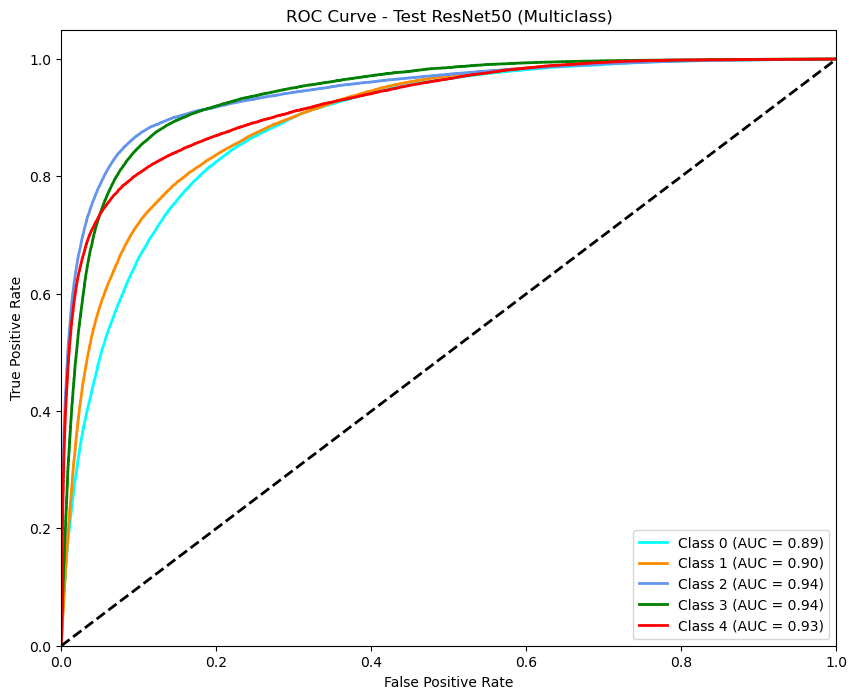

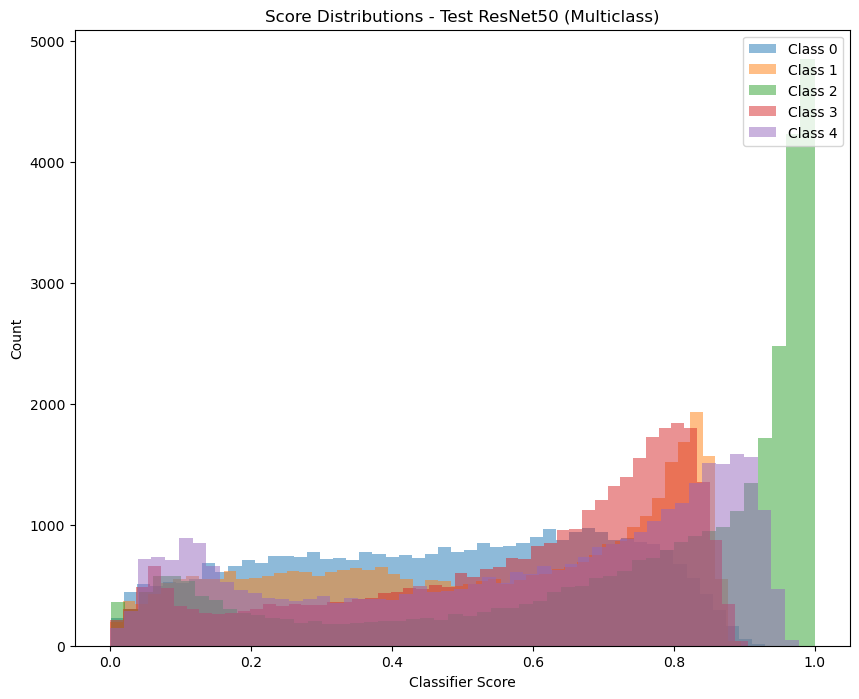

In [31]:

# Select device: use GPU if available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_gpus = torch.cuda.device_count()  # Count the number of available GPUs


# Create DataLoader for the test set with a batch size of 32
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32)

# Directory where the 5 trained models are saved
model_dir = "5models_ResNet_5types_170k"

# Run ensemble testing across the 5 saved models
test_acc, test_auc, true_all_labels, test_all_probs = ensemble_test(
    test_loader=test_loader,
    model_dir=model_dir,
    device=device,
)

# Print final test accuracy and AUC score
print(f'\nTesting Accuracy: {test_acc:.4f}')
print(f'Testing AUC (macro-average): {test_auc:.4f}')

# Extract ground truth labels and full class probability predictions
y_true = np.array(true_all_labels)  # shape: [n_samples]
y_pred = np.array(test_all_probs)   # shape: [n_samples, n_classes]

# Generate ROC curve and class score distributions for all classes
plot_roc_curve(y_true, y_pred, "Test ResNet50 (Multiclass)")
plot_score_distributions(y_true, y_pred, "Test ResNet50 (Multiclass)")

# Save the predictions and labels into a .npz file for later analysis or plotting
model_name = "ROC-resnet-170k"
np.savez(f'{model_name}_multiclass.npz', y_true=y_true, y_pred=y_pred)

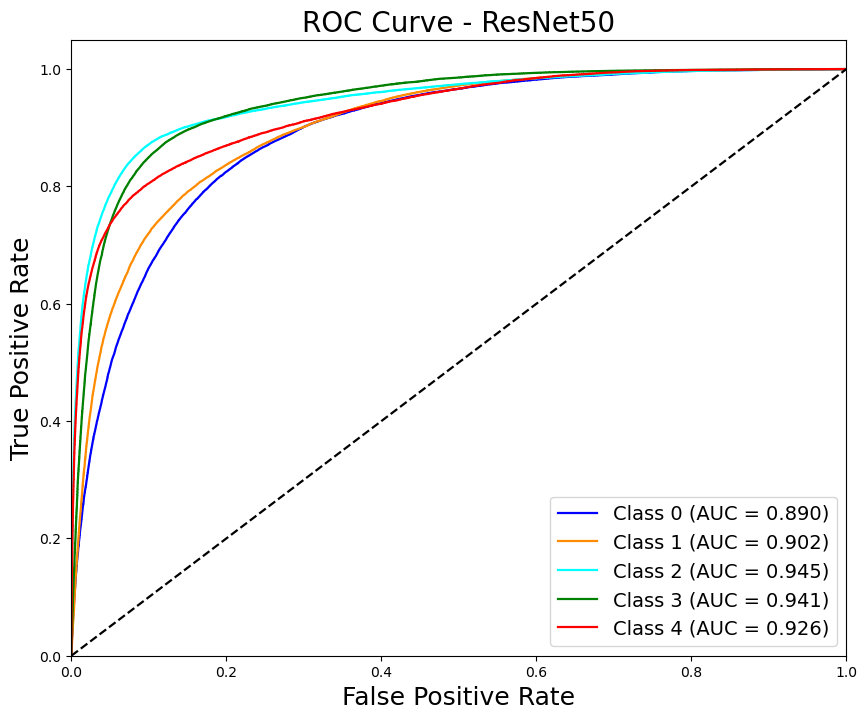

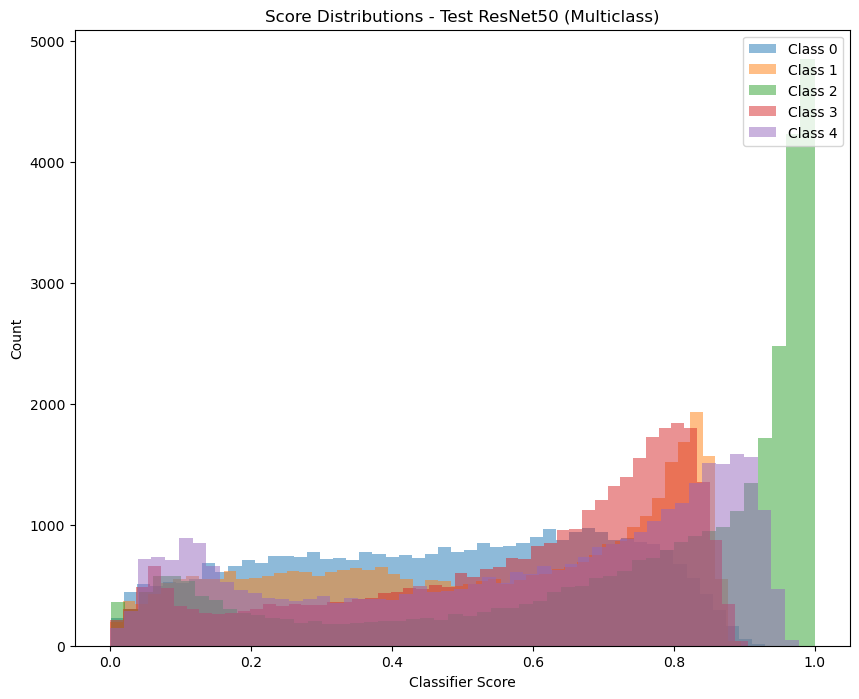

In [40]:
# Generate ROC curve and class score distributions for all classes
plot_roc_curve(y_true, y_pred, "ResNet50")
plot_score_distributions(y_true, y_pred, "Test ResNet50 (Multiclass)")
